1. Enable data augmentation, and precompute=True
2. Use lr_find() to find highest learning rate where loss is still clearly improving
3. Train last layer from precomputed activations for 1-2 epochs
4. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
5. Unfreeze all layers
6. Set earlier layers to 3x-10x lower learning rate than next higher layer
7. Use lr_find() again
8. Train full network with cycle_mult=2 until over-fitting


# Pre-requistes

In [39]:
!date

Fri Feb  2 00:35:03 EST 2018


In [40]:
project_name='plant-seedlings-classification'

In [41]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import os, sys

In [43]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [44]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
from planet import *

In [45]:
PATH = "/home/paperspace/data/seeds/"
#PATH = "/Users/vinod/programming/DL/data/seedlings/"
assert os.path.exists(PATH)

## Get data

### Directory based structure

In [18]:
!ls {PATH}

models	sample_submission.csv.zip  test  tmp  train  train.zip	valid


In [19]:
notebook_dir = os.getcwd()
notebook_dir

'/home/paperspace/fastai/courses/dl1'

In [20]:
os.chdir(PATH)

In [21]:
! pwd

/home/paperspace/data/seeds


In [22]:
dir_list = os.listdir('train/')
dir_list.remove('.DS_Store')
dir_list

ValueError: list.remove(x): x not in list

In [50]:
from random import sample

for dir in dir_list:
    print(dir)
    #files = np.random.permutation(os.listdir(f'train/{dir}'))
    files = os.listdir(f'train/{dir}')
    no_of_valid_files = round(len(files) / 10) # 10%
    print(no_of_valid_files)
    random_files = sample(files, no_of_valid_files)
    print(random_files[:3])
    for file in random_files:
        os.renames(f'{PATH}/train/{dir}/{file}', f'valid/{dir}/{file}') 
    os.listdir(f'{PATH}valid/{dir}/')

Cleavers
29
['16e0482dd.png', '11c5eb5b6.png', '5abac7fbf.png']
Sugar beet
38
['d7b6e4654.png', '2d0c2c01e.png', '73d86199e.png']
Common Chickweed
61
['a23bbb5c9.png', 'a5b9d84a3.png', '02ad544a4.png']
Loose Silky-bent
65
['559dae100.png', '58f28c75f.png', '39e081b5f.png']
Scentless Mayweed
52
['0eaa11631.png', '275152b11.png', '818952af9.png']
Shepherds Purse
23
['bd1e1acdd.png', 'b085af335.png', '93d6a65a2.png']
Fat Hen
48
['e5e1416a2.png', '3c2e5c7ad.png', '7f731311e.png']
Common wheat
22
['b032c75ba.png', 'ebdd5e41a.png', '5386db683.png']
Black-grass
26
['69ad6773e.png', '42336b187.png', 'f5ca3d442.png']
Small-flowered Cranesbill
50
['d52d13ac9.png', 'f6fa5e429.png', 'fae94cdba.png']
Charlock
39
['f0a9c3b66.png', 'd37702684.png', 'b50f12de9.png']
Maize
22
['62a1614a2.png', '69f06fcbc.png', '5dfa39111.png']


In [23]:
!ls {PATH}valid

Black-grass  Common Chickweed  Loose Silky-bent   Shepherds Purse
Charlock     Common wheat      Maize		  Small-flowered Cranesbill
Cleavers     Fat Hen	       Scentless Mayweed  Sugar beet


In [24]:
# MAX size
files = !ls -S {PATH}valid/Maize | head
files

['f98add892.png',
 'd99129a77.png',
 '4b825327e.png',
 '3b6bc2e4c.png',
 '7736aedff.png',
 'fc02b8466.png',
 '362eee504.png',
 '92c06eaca.png',
 'f60369038.png',
 '70b85477d.png']

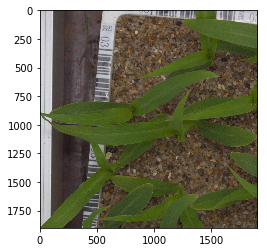

In [25]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [26]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(1900, 1900, 3)

In [27]:
# MIN size
files = !ls -rS {PATH}valid/Maize | head
files

['a76555ad2.png',
 '2bc5905e2.png',
 '2b968a9e0.png',
 '23a60f63f.png',
 '365ff4533.png',
 '8bfe6860d.png',
 '5c826024a.png',
 '6e9ff31e7.png',
 'e364ace75.png',
 '8c6fba454.png']

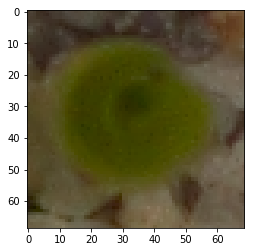

In [28]:
img = plt.imread(f'{PATH}valid/Maize/{files[0]}')
plt.imshow(img)

In [29]:
# Image data (pixel_col, pixel_row, RGB)
img.shape 

(69, 69, 3)

In [46]:
os.chdir(notebook_dir)

In [47]:
def get_tfms(f_model, size): return tfms_from_model(f_model, size)

In [48]:
def get_aug_tfms(f_model, size): return tfms_from_model(f_model, size, aug_tfms=transforms_side_on, max_zoom=1.1)

In [49]:
def get_data_from_csv(f_model, sz, tfms):
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [50]:
def get_data_from_dir(f_mode, sz, tfms):
    return ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz), test_name='test')

# Enable data augmentation, and precompute=True

## Initial model setup

In [57]:
arch=resnet34
size=64
#metrics=[f2]

In [66]:
data = get_data_from_dir(arch, size, get_aug_tfms(arch, size))

In [67]:
learn = ConvLearner.pretrained(arch, data)

# Use lr_find() to find highest learning rate where loss is still clearly improving

In [68]:
discovered_learning_rate = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 69%|██████▊   | 46/67 [00:07<00:03,  6.19it/s, loss=2.69]

Exception in thread Thread-7:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 93%|█████████▎| 62/67 [00:10<00:00,  6.11it/s, loss=28.2]


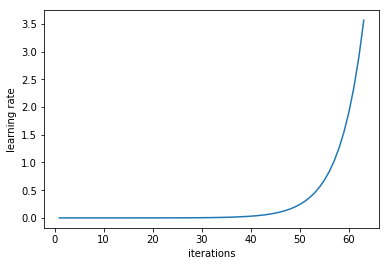

In [69]:
learn.sched.plot_lr()

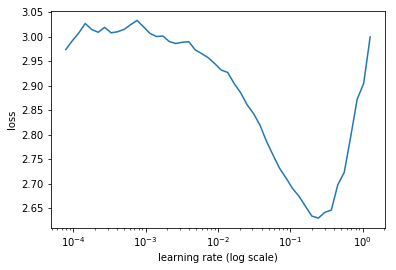

In [70]:
learn.sched.plot()

# Train last layer from precomputed activations for 1-2 epochs

In [71]:
learning_rate = 0.15
learning_rates = [learning_rate/9, learning_rate/3, learning_rate]

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      2.270421   1.470489   0.524233  
    1      1.772781   1.352822   0.524306                 
    2      1.401178   1.234698   0.592593                 
    3      1.391443   1.299902   0.534722                 
    4      1.300105   1.212204   0.58138                  
    5      1.135296   1.153267   0.591146                 
    6      1.021818   1.138859   0.613354                 

CPU times: user 5min 44s, sys: 22.6 s, total: 6min 7s
Wall time: 1min 34s


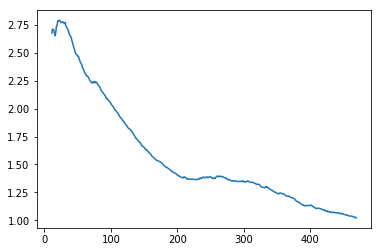

In [72]:
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.101704   0.744785   0.757378  
    1      0.84034    0.598278   0.793258                  
    2      0.517474   0.47865    0.861834                  
    3      0.557319   0.991355   0.71781                   
    4      0.435229   0.486264   0.833984                  
    5      0.267358   0.378737   0.875506                  
    6      0.179604   0.334051   0.893808                  

CPU times: user 7min 18s, sys: 56.1 s, total: 8min 14s
Wall time: 3min 17s


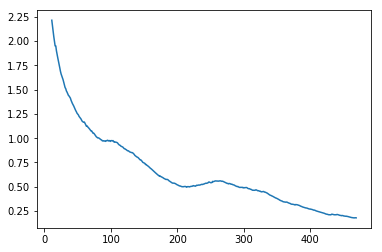

In [73]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [74]:
size = 128
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.879212   0.712437   0.752025  
    1      0.780788   0.705516   0.773727                  
    2      0.665206   0.630247   0.789352                  
    3      0.684688   0.630717   0.790799                  
    4      0.64673    0.57443    0.808883                  
    5      0.586231   0.537669   0.812789                  
    6      0.544053   0.532005   0.808883                  

CPU times: user 7min 19s, sys: 41.6 s, total: 8min
Wall time: 2min 24s


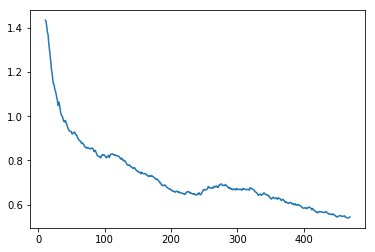

In [75]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.592574   0.370079   0.884766  
    1      0.461765   0.453186   0.84498                   
    2      0.260666   0.20697    0.931641                  
    3      0.303822   0.463017   0.84375                   
    4      0.242249   0.243237   0.914062                  
    5      0.160941   0.200844   0.931641                  
    6      0.103735   0.172067   0.945312                  

CPU times: user 9min 33s, sys: 1min 50s, total: 11min 23s
Wall time: 5min 43s


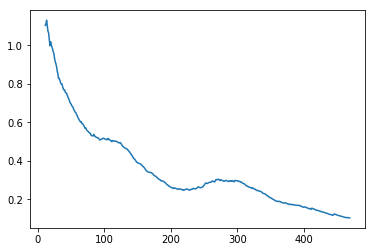

In [76]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

In [77]:
size = 300
learn.set_data(get_data_from_dir(arch, size, get_aug_tfms(arch, size)))

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.542585   0.439856   0.857928  
    1      0.463033   0.343214   0.880136                  
 54%|█████▎    | 36/67 [00:38<00:32,  1.06s/it, loss=0.414]    3      0.416917   0.301183   0.902344  
    4      0.370853   0.301395   0.910156                  
    5      0.324507   0.262381   0.921875                  
    6      0.290939   0.257114   0.925781                  

CPU times: user 13min 15s, sys: 3min 39s, total: 16min 55s
Wall time: 9min 12s


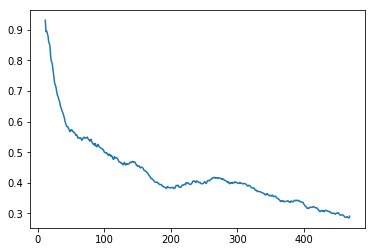

In [78]:
learn.freeze()
%time learn.fit(learning_rate, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_last_layer_{size}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.489712   0.26284    0.919922  
    1      0.378705   0.403781   0.878183                  
    2      0.212245   0.155901   0.953125                  
    3      0.25653    1.732097   0.623553                  
    4      0.199154   0.273534   0.919922                  
    5      0.119262   0.127317   0.964844                  
    6      0.080866   0.128118   0.957031                   

CPU times: user 21min 21s, sys: 7min 9s, total: 28min 31s
Wall time: 20min 49s


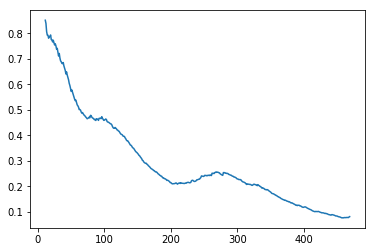

In [79]:
learn.unfreeze()

%time learn.fit(learning_rates, 3, cycle_len=1, cycle_mult=2)

learn.sched.plot_loss()

learn.save(f'{project_name}_entire_network_{size}')

# Check accuracy

## Validation set

In [84]:
log_preds, y = learn.TTA()

In [85]:
log_preds.shape

(5, 475, 12)

In [87]:
log_preds[:,0,:]

array([[ -0.1838 , -17.88607, -15.08258, -13.14373,  -7.26453, -11.7423 ,  -1.78866, -15.20303, -12.54287,
        -15.36302, -16.5851 , -15.46299],
       [ -0.1838 , -17.88607, -15.08258, -13.14373,  -7.26453, -11.7423 ,  -1.78866, -15.20303, -12.54287,
        -15.36302, -16.5851 , -15.46299],
       [ -0.1838 , -17.88607, -15.08258, -13.14373,  -7.26453, -11.7423 ,  -1.78866, -15.20303, -12.54287,
        -15.36302, -16.5851 , -15.46299],
       [ -0.1838 , -17.88607, -15.08258, -13.14373,  -7.26453, -11.7423 ,  -1.78866, -15.20303, -12.54287,
        -15.36302, -16.5851 , -15.46299],
       [ -0.1838 , -17.88607, -15.08258, -13.14373,  -7.26453, -11.7423 ,  -1.78866, -15.20303, -12.54287,
        -15.36302, -16.5851 , -15.46299]], dtype=float32)

In [88]:
y.shape

(475,)

In [92]:
y[:5]

array([0, 0, 0, 0, 0])

In [86]:
probs = np.mean(np.exp(log_preds), 0)

In [93]:
probs.shape

(475, 12)

In [94]:
probs[0,:]

array([0.8321 , 0.     , 0.     , 0.     , 0.0007 , 0.00001, 0.16718, 0.     , 0.     , 0.     , 0.     ,
       0.     ], dtype=float32)

In [96]:
accuracy(probs, y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


## Test set

In [97]:
learn.data.classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

In [98]:
test_log_preds, test_y = learn.TTA(is_test=True)
test_probs = np.mean(np.exp(test_log_preds), 0)
print(accuracy(test_probs, test_y))

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)


In [99]:
print(test_probs.shape)
print(test_probs[:4])
print(test_probs[0, 0])

(794, 12)
[[0.06459 0.00013 0.00052 0.      0.93308 0.00105 0.00039 0.00001 0.      0.      0.      0.00022]
 [0.      0.      0.      0.      0.      0.00001 0.      0.      0.      0.00007 0.99991 0.     ]
 [0.      0.      0.      0.      0.      0.00001 0.      0.      0.      0.00004 0.99995 0.     ]
 [0.      0.      0.      0.      0.      0.      0.      1.      0.      0.      0.      0.     ]]
0.06459238


In [100]:
class_indexes = np.argmax(test_probs, axis=1)

In [101]:
learn.data.classes[class_indexes[0]]

'Common wheat'

# Submit to kaggle (optional)

In [102]:
test_classes = [learn.data.classes[i] for i in class_indexes]
print(len(test_classes))
print(test_classes[:5])


794
['Common wheat', 'Small-flowered Cranesbill', 'Small-flowered Cranesbill', 'Maize', 'Small-flowered Cranesbill']


In [103]:
test_dl = learn.data.test_dl
test_filenames = test_dl.dataset.fnames
print(len(test_filenames))
print(test_filenames[:5])

794
['test/79e5ea8fa.png', 'test/3a909ead8.png', 'test/599691cd9.png', 'test/5ca2687a4.png', 'test/3dd52bd2a.png']


In [104]:
fileIds = np.array([f[5:] for f in test_filenames])
fileIds[:5]

array(['79e5ea8fa.png', '3a909ead8.png', '599691cd9.png', '5ca2687a4.png', '3dd52bd2a.png'], dtype='<U13')

In [105]:
submission = np.stack([fileIds,test_classes], axis=1)
submission[:5]

array([['79e5ea8fa.png', 'Common wheat'],
       ['3a909ead8.png', 'Small-flowered Cranesbill'],
       ['599691cd9.png', 'Small-flowered Cranesbill'],
       ['5ca2687a4.png', 'Maize'],
       ['3dd52bd2a.png', 'Small-flowered Cranesbill']], dtype='<U25')

In [106]:
!pwd

/home/paperspace/fastai/courses/dl1


In [107]:
now = datetime.datetime.now()
submission_file_name = f'plant-seed-submission-{str(now)}.csv'
# changed the decimal format from .5 to .10 and NO clip and moved into top 8% on kaggle (from 10%)
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

In [108]:
from IPython.display import FileLink
FileLink(submission_file_name)

/home/paperspace/fastai/courses/dl1/plant-seed-submission-2018-02-02 04:01:35.341652.csv

In [ ]:
!date